Copyright ENEOS, Corp., Preferred Computational Chemistry, Inc. and Preferred Networks, Inc. as contributors to Matlantis contrib project

# 不均一系触媒上の反応解析（NEB法）


目次:
 - **[1. BulkからSlab作成](#chap1)**
 - **[2. MoleculeをSlab上に配置、始状態（反応前）と終状態（反応後）を作成](#chap2)**
 - **[3. NEB計算](#chap3)**
 - **[4. NEB計算結果の確認と遷移状態構造取得](#chap4)**
 - **[5. 遷移状態構造の構造最適化（by Sella）](#chap5)**
 - **[6. 遷移状態の振動解析](#chap6)**
 - **[7. 遷移状態からの追加解析（擬似IRC計算）](#chap7)**

<a id="chap0"></a>
## セットアップ

In [1]:
# time.sleep(3600*10)
# # notebookで1.5時間無処理状態が続きますとkernelが自動でshutdownします。
# # kernelを保持したい場合に上の行の#を外して実行してください。

In [2]:
!pip install pfp-api-client
!pip install pandas tqdm matplotlib seaborn optuna sella sklearn torch torch_dftd

# # 初回使用時のみ、ライブラリのインストールをお願いします。

In [3]:
# 汎用モジュール
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from IPython.display import display_png
from IPython.display import Image as ImageWidget
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider
from matplotlib.animation import PillowWriter
import seaborn as sns
import math
import optuna
import nglview as nv
import os,sys,csv,glob,shutil,re,time
from pathlib import Path
from PIL import Image, ImageDraw

# sklearn
from sklearn.metrics import mean_absolute_error


# ASE
import ase
from ase import Atoms, units
from ase.units import Bohr,Rydberg,kJ,kB,fs,Hartree,mol,kcal
from ase.io import read, write
from ase.build import surface, molecule, add_adsorbate
from ase.cluster.cubic import FaceCenteredCubic
from ase.constraints import FixAtoms, FixedPlane, FixBondLength, ExpCellFilter
from ase.neb import SingleCalculatorNEB
from ase.neb import NEB
from ase.vibrations import Vibrations
from ase.visualize import view
from ase.optimize import QuasiNewton
from ase.thermochemistry import IdealGasThermo
from ase.build.rotate import minimize_rotation_and_translation
from ase.visualize import view
from ase.optimize import BFGS, LBFGS, FIRE
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary
from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin
from ase.md.nptberendsen import NPTBerendsen, Inhomogeneous_NPTBerendsen
from ase.md import MDLogger
from ase.io import read, write, Trajectory
# from ase.calculators.dftd3 import DFTD3
from ase.build import sort

from sella import Sella, Constraints
from torch_dftd.torch_dftd3_calculator import TorchDFTD3Calculator

# PFP
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator
from pfp_api_client.pfp.estimator import EstimatorCalcMode

estimator = Estimator(calc_mode="CRYSTAL")
calculator = ASECalculator(estimator)
# calculatorD = DFTD3(dft=calculator, xc = 'pbe', label="ase_dftd3_3") #　　　いままでと同じコードでD3計算とする場合
calculatorD = TorchDFTD3Calculator(dft=calculator, xc="pbe", label="dftd3") #　　　いままでと同じコードでD3計算とする場合

In [4]:
# このセルはexperimental, unexpectedな元素の計算を行う際にでるwarningを抑制するためのコマンドです。必要なときのみ実行してください。
# from pfp_api_client.utils.messages import MessageEnum
# estimator.set_message_status(message=MessageEnum.ExperimentalElementWarning, message_enable=False)
# estimator.set_message_status(message=MessageEnum.UnexpectedElementWarning, message_enable=False)

In [5]:
def myopt(m,sn = 10,constraintatoms=[],cbonds=[]):
    fa = FixAtoms(indices=constraintatoms)
    fb = FixBondLengths(cbonds,tolerance=1e-5,)
    m.set_constraint([fa,fb])
    m.set_calculator(calculator)
    maxf = np.sqrt(((m.get_forces())**2).sum(axis=1).max())
    print("ini   pot:{:.4f},maxforce:{:.4f}".format(m.get_potential_energy(),maxf))
    de = -1 
    s = 1
    ita = 50
    while ( de  < -0.001 or de > 0.001 ) and s <= sn :
        opt = BFGS(m,maxstep=0.04*(0.9**s),logfile=None)
        old  =  m.get_potential_energy() 
        opt.run(fmax=0.0005,steps =ita)
        maxf = np.sqrt(((m.get_forces())**2).sum(axis=1).max())
        de =  m.get_potential_energy()  - old
        print("{} pot:{:.4f},maxforce:{:.4f},delta:{:.4f}".format(s*ita,m.get_potential_energy(),maxf,de))
        s += 1
    return m

def opt_cell_size(m,sn = 10, iter_count = False): # m:Atomsオブジェクト
    m.set_constraint() # clear constraint
    m.set_calculator(calculator)
    maxf = np.sqrt(((m.get_forces())**2).sum(axis=1).max()) # √(fx^2 + fy^2 + fz^2)の一番大きいものを取得
    ucf = ExpCellFilter(m)
    print("ini   pot:{:.4f},maxforce:{:.4f}".format(m.get_potential_energy(),maxf))
    de = -1 
    s = 1
    ita = 50
    while ( de  < -0.01 or de > 0.01 ) and s <= sn :
        opt = BFGS(ucf,maxstep=0.04*(0.9**s),logfile=None)
        old  =  m.get_potential_energy() 
        opt.run(fmax=0.005,steps =ita)
        maxf = np.sqrt(((m.get_forces())**2).sum(axis=1).max())
        de =  m.get_potential_energy()  - old
        print("{} pot:{:.4f},maxforce:{:.4f},delta:{:.4f}".format(s*ita,m.get_potential_energy(),maxf,de))
        s += 1
    if iter_count == True:
        return m, s*ita
    else:
        return m
    
#表面を作る
def makesurface(atoms,miller_indices=(1,1,1),layers=4,rep=[4,4,1]):
    s1 = surface(atoms, miller_indices,layers)
    s1.center(vacuum=10.0, axis=2)
    s1 = s1.repeat(rep)
    s1.set_positions(s1.get_positions() - [0,0,min(s1.get_positions()[:,2])])
    s1.pbc = True
    return s1

In [6]:
import threading
import time
from math import pi
from typing import Dict, List, Optional

import nglview as nv
from ase import Atoms
from ase.constraints import FixAtoms
from ase.optimize import BFGS
from ase.visualize import view
from IPython.display import display
from ipywidgets import (
    Button,
    Checkbox,
    FloatSlider,
    GridspecLayout,
    HBox,
    IntSlider,
    Label,
    Text,
    Textarea,
)
from nglview.widget import NGLWidget


def save_image(filename: str, v: NGLWidget):
    """Save nglview image.

    Note that it should be run on another thread.
    See: https://github.com/nglviewer/nglview/blob/master/docs/FAQ.md#how-to-make-nglview-view-object-write-png-file

    Args:
        filename (str):
        v (NGLWidget):
    """
    image = v.render_image()
    while not image.value:
        time.sleep(0.1)
    with open(filename, "wb") as fh:
        fh.write(image.value)


class SurfaceEditor:
    """Structure viewer/editor"""

    struct: List[Dict]  # structure used for nglview drawing.

    def __init__(self, atoms: Atoms):
        self.atoms = atoms
        self.vh = view(atoms, viewer="ngl")
        self.v: NGLWidget = self.vh.children[0]  # VIEW
        self.v._remote_call("setSize", args=["450px", "450px"])
        self.recont()  # Add controller
        self.set_representation()
        self.set_atoms()
        self.pots = []
        self.traj = []
        self.cal_nnp()

    def display(self):
        display(self.vh)

    def recont(self):
        self.vh.setatoms = FloatSlider(
            min=0, max=50, step=0.1, value=8, description="atoms z>"
        )
        self.vh.setatoms.observe(self.set_atoms)
        self.vh.selected_atoms_label = Label("Selected atoms:")
        self.vh.selected_atoms_textarea = Textarea()
        selected_atoms_hbox = HBox(
            [self.vh.selected_atoms_label, self.vh.selected_atoms_textarea]
        )
        self.vh.move = FloatSlider(
            min=0.1, max=2, step=0.1, value=0.5, description="move"
        )

        grid1 = GridspecLayout(2, 3)
        self.vh.xplus = Button(description="X+")
        self.vh.xminus = Button(description="X-")
        self.vh.yplus = Button(description="Y+")
        self.vh.yminus = Button(description="Y-")
        self.vh.zplus = Button(description="Z+")
        self.vh.zminus = Button(description="Z-")
        self.vh.xplus.on_click(self.move)
        self.vh.xminus.on_click(self.move)
        self.vh.yplus.on_click(self.move)
        self.vh.yminus.on_click(self.move)
        self.vh.zplus.on_click(self.move)
        self.vh.zminus.on_click(self.move)
        grid1[0, 0] = self.vh.xplus
        grid1[0, 1] = self.vh.yplus
        grid1[0, 2] = self.vh.zplus
        grid1[1, 0] = self.vh.xminus
        grid1[1, 1] = self.vh.yminus
        grid1[1, 2] = self.vh.zminus

        self.vh.rotate = FloatSlider(
            min=1, max=90, step=1, value=30, description="rotate"
        )
        grid2 = GridspecLayout(2, 3)
        self.vh.xplus2 = Button(description="X+")
        self.vh.xminus2 = Button(description="X-")
        self.vh.yplus2 = Button(description="Y+")
        self.vh.yminus2 = Button(description="Y-")
        self.vh.zplus2 = Button(description="Z+")
        self.vh.zminus2 = Button(description="Z-")
        self.vh.xplus2.on_click(self.rotate)
        self.vh.xminus2.on_click(self.rotate)
        self.vh.yplus2.on_click(self.rotate)
        self.vh.yminus2.on_click(self.rotate)
        self.vh.zplus2.on_click(self.rotate)
        self.vh.zminus2.on_click(self.rotate)
        grid2[0, 0] = self.vh.xplus2
        grid2[0, 1] = self.vh.yplus2
        grid2[0, 2] = self.vh.zplus2
        grid2[1, 0] = self.vh.xminus2
        grid2[1, 1] = self.vh.yminus2
        grid2[1, 2] = self.vh.zminus2

        self.vh.nnptext = Textarea(disabled=True)

        self.vh.opt_step = IntSlider(
            min=0,
            max=100,
            step=1,
            value=10,
            description="Opt steps",
        )
        self.vh.constraint_checkbox = Checkbox(
            value=True,
            description="Opt only selected atoms",
        )
        self.vh.run_opt_button = Button(
            description="Run mini opt",
            tooltip="Execute BFGS optimization with small step update."
        )
        self.vh.run_opt_button.on_click(self.run_opt)
        opt_hbox = HBox([self.vh.constraint_checkbox, self.vh.run_opt_button])

        self.vh.filename_text = Text(value="screenshot.png", description="filename: ")
        self.vh.download_image_button = Button(
            description="download image",
            tooltip="Download current frame to your local PC",
        )
        self.vh.download_image_button.on_click(self.download_image)
        self.vh.save_image_button = Button(
            description="save image",
            tooltip="Save current frame to file.\n"
                    "Currently .png and .html are supported.\n"
                    "It takes a bit time, please be patient.",
        )
        self.vh.save_image_button.on_click(self.save_image)

        self.vh.update_display = Button(
            description="update_display",
            tooltip="Refresh display. It can be used when target atoms is updated in another cell..",
        )
        self.vh.update_display.on_click(self.update_display)

        r = list(self.vh.control_box.children)
        r += [
            self.vh.setatoms,
            selected_atoms_hbox,
            self.vh.move,
            grid1,
            self.vh.rotate,
            grid2,
            self.vh.nnptext,
            self.vh.opt_step,
            opt_hbox,
            self.vh.filename_text,
            HBox([self.vh.download_image_button, self.vh.save_image_button]),
            self.vh.update_display,
        ]
        self.vh.control_box.children = tuple(r)

    def set_representation(self, bcolor: str = "white", unitcell: bool = True):
        self.v.background = bcolor
        self.struct = self.get_struct(self.atoms)
        self.v.add_representation(repr_type="ball+stick")
        self.v.control.spin([0, 1, 0], pi * 1.1)
        self.v.control.spin([1, 0, 0], -pi * 0.45)
        thread = threading.Thread(target=self.changestr)
        thread.start()

    def changestr(self):
        time.sleep(2)
        self.v._remote_call("replaceStructure", target="Widget", args=self.struct)

    def get_struct(self, atoms: Atoms, ext="pdb") -> List[Dict]:
        struct = nv.ASEStructure(atoms, ext=ext).get_structure_string()
        for c in range(len(atoms)):
            struct = struct.replace("MOL     1", "M0    " + str(c).zfill(3), 1)
        struct = [dict(data=struct, ext=ext)]
        return struct

    def cal_nnp(self):
        pot = self.atoms.get_potential_energy()
        mforce = (((self.atoms.get_forces()) ** 2).sum(axis=1).max()) ** 0.5
        self.pot = pot
        self.mforce = mforce
        self.vh.nnptext.value = f"pot energy: {pot} eV\nmax force : {mforce} eV/A"
        self.pots += [pot]
        self.traj += [self.atoms.copy()]

    def update_display(self, clicked_button: Optional[Button] = None):
        print("update display!")
        struct = self.get_struct(self.atoms)
        self.struct = struct
        self.v._remote_call("replaceStructure", target="Widget", args=struct)
        self.cal_nnp()

    def set_atoms(self, slider: Optional[FloatSlider] = None):
        """Update text area based on the atoms position `z` greater than specified value."""
        smols = [
            i for i, atom in enumerate(self.atoms) if atom.z >= self.vh.setatoms.value
        ]
        self.vh.selected_atoms_textarea.value = ", ".join(map(str, smols))

    def get_selected_atom_indices(self) -> List[int]:
        selected_atom_indices = self.vh.selected_atoms_textarea.value.split(",")
        selected_atom_indices = [int(a) for a in selected_atom_indices]
        return selected_atom_indices

    def move(self, clicked_button: Button):
        a = self.vh.move.value

        for index in self.get_selected_atom_indices():
            if clicked_button.description == "X+":
                self.atoms[index].position += [a, 0, 0]
            elif clicked_button.description == "X-":
                self.atoms[index].position -= [a, 0, 0]
            elif clicked_button.description == "Y+":
                self.atoms[index].position += [0, a, 0]
            elif clicked_button.description == "Y-":
                self.atoms[index].position -= [0, a, 0]
            elif clicked_button.description == "Z+":
                self.atoms[index].position += [0, 0, a]
            elif clicked_button.description == "Z-":
                self.atoms[index].position -= [0, 0, a]
        self.update_display()

    def rotate(self, clicked_button: Button):
        atom_indices = self.get_selected_atom_indices()
        deg = self.vh.rotate.value
        temp = self.atoms[atom_indices]

        if clicked_button.description == "X+":
            temp.rotate(deg, "x", center="COP")
        elif clicked_button.description == "X-":
            temp.rotate(-deg, "x", center="COP")
        elif clicked_button.description == "Y+":
            temp.rotate(deg, "y", center="COP")
        elif clicked_button.description == "Y-":
            temp.rotate(-deg, "y", center="COP")
        elif clicked_button.description == "Z+":
            temp.rotate(deg, "z", center="COP")
        elif clicked_button.description == "Z-":
            temp.rotate(-deg, "z", center="COP")
        rotep = temp.positions
        for i, atom in enumerate(atom_indices):
            self.atoms[atom].position = rotep[i]
        self.update_display()

    def run_opt(self, clicked_button: Button):
        """OPT only specified steps and FIX atoms if NOT in text atoms list"""
        if self.vh.constraint_checkbox.value:
            # Fix non selected atoms. Only opt selected atoms.
            print("Opt with selected atoms: fix non selected atoms")
            atom_indices = self.get_selected_atom_indices()
            constraint_atom_indices = [
                i for i in range(len(self.atoms)) if i not in atom_indices
            ]
            self.atoms.set_constraint(FixAtoms(indices=constraint_atom_indices))
        opt = BFGS(self.atoms, maxstep=0.04, logfile=None)
        steps: Optional[int] = self.vh.opt_step.value
        if steps < 0:
            steps = None  # When steps=-1, opt until converged.
        opt.run(fmax=0.0001, steps=steps)
        print(f"Run opt for {steps} steps")
        self.update_display()

    def download_image(self, clicked_button: Optional[Button] = None):
        filename = self.vh.filename_text.value
        self.v.download_image(filename=filename)

    def save_image(self, clicked_button: Optional[Button] = None):
        filename = self.vh.filename_text.value
        if filename.endswith(".png"):
            thread = threading.Thread(
                target=save_image, args=(filename, self.v), daemon=True
            )
            # thread.daemon = True
            thread.start()
        elif filename.endswith(".html"):
            nv.write_html(filename, [self.v])  # type: ignore
        else:
            print(f"filename {filename}: extension not supported!")


<a id="chap1"></a>
## 1. BulkからSlab作成

### 1-1 Bulk構造を読み込みから作成まで

今回はMaterials Projectからダウンロードしたcifファイルをinputフォルダに入れて読み込み

Input cif file is from  
A. Jain*, S.P. Ong*, G. Hautier, W. Chen, W.D. Richards, S. Dacek, S. Cholia, D. Gunter, D. Skinner, G. Ceder, K.A. Persson (*=equal contributions)  
The Materials Project: A materials genome approach to accelerating materials innovation
APL Materials, 2013, 1(1), 011002.  
[doi:10.1063/1.4812323](http://dx.doi.org/10.1063/1.4812323)  
[[bibtex]](https://materialsproject.org/static/docs/jain_ong2013.349ca3156250.bib)  
Licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)  

In [7]:
bulk = read("input/Rh_mp-74_conventional_standard.cif")
print("原子数 =", len(bulk))
print("initial 格子定数 =", bulk.cell.cellpar())

opt_cell_size(bulk)
print ("optimized 格子定数 =", bulk.cell.cellpar())

原子数 = 4
initial 格子定数 = [ 3.843898  3.843898  3.843898 90.       90.       90.      ]
ini   pot:-22.9685,maxforce:0.0000
50 pot:-22.9735,maxforce:0.0000,delta:-0.0050
optimized 格子定数 = [ 3.83034391  3.83034342  3.83034361 89.99999637 90.0000084  90.00000551]


[sort](https://wiki.fysik.dtu.dk/ase/ase/build/tools.html#ase.build.sort)関数は、元素番号に応じて順序をソートする関数です。

In [8]:
bulk = bulk.repeat([2,2,2])               
bulk = sort(bulk)
bulk.positions += [0.01,0,0]   # 面を切るときに変なところで切れるのを防ぐために少し下駄を履かせます。
v = view(bulk, viewer='ngl')
v.view.add_representation("ball+stick")
display(v)

### 1-2 Slab構造を作成まで

bulk構造から任意のミラー指数でslab構造を作成。<br/>
`miller_indices=(x,y,z)`で指定できます。 `makesurface` は中で [surface](https://wiki.fysik.dtu.dk/ase//ase/build/surface.html#create-specific-non-common-surfaces) 関数を使用して表面構造を作成しています。

In [9]:
slab = makesurface(bulk, miller_indices=(1,1,1), layers=2, rep=[1,1,1])
slab = sort(slab)
slab.positions += [1,1,0]         # 少しだけ位置調整
slab.wrap()                       # してからWRAP

v = view(slab, viewer='ngl')
v.view.add_representation("ball+stick")
display(v)

### 1-3 作成したslabのz座標を確認

slabの最も高い座標確認（吸着構造を作成するときに必要）<br/>
slabの層ごとの座標を確認（何層目までを固定するのか決めるのに必要）

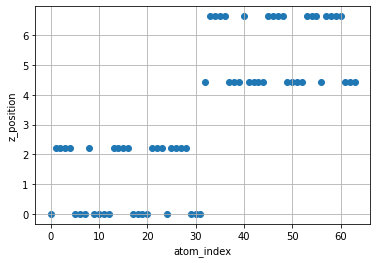

In [10]:
# 原子のz_positionを確認。
z_pos = pd.DataFrame({
    "symbol": slab.get_chemical_symbols(),
    "z": slab.get_positions()[:, 2]
})

plt.scatter(z_pos.index, z_pos["z"])
plt.grid(True)
plt.xlabel("atom_index")
plt.ylabel("z_position")
plt.show()

In [11]:
print("highest position (z) =", z_pos["z"].max())

highest position (z) = 6.634349612126


### 1-4 表面切り出したslab構造の下層を固定して構造最適化

[FixAtoms](https://wiki.fysik.dtu.dk/ase//ase/constraints.html#ase.constraints.FixAtoms) を用いることで、slab構造の下層の原子のみを固定してOptを実行できます。<br/>

ここでは１A以下を固定しており、一番下の層のみが固定されます。
表面の原子位置が緩和されるはずです。

In [12]:
%%time
c = FixAtoms(indices=[atom.index for atom in slab if atom.position[2] <= 1])       # 1A以下を固定
slab.set_constraint(c)
slab.calc = calculator

os.makedirs("output", exist_ok=True)
BFGS_opt = BFGS(slab, trajectory="output/slab_opt.traj")#, logfile=None)
BFGS_opt.run(fmax=0.005)

      Step     Time          Energy         fmax
BFGS:    0 02:07:15     -341.322486        0.3229
BFGS:    1 02:07:15     -341.346574        0.2887
BFGS:    2 02:07:15     -341.434290        0.2578
BFGS:    3 02:07:15     -341.449323        0.2547
BFGS:    4 02:07:15     -341.569873        0.1973
BFGS:    5 02:07:15     -341.580294        0.1860
BFGS:    6 02:07:15     -341.611102        0.0594
BFGS:    7 02:07:15     -341.613782        0.0217
BFGS:    8 02:07:15     -341.614080        0.0020
CPU times: user 306 ms, sys: 394 ms, total: 699 ms
Wall time: 707 ms


True

実際のOptの経過を見てみると、上3層のみの構造最適化がされている事がわかります。

In [13]:
# v = view(slab, viewer='ngl')
v = view(Trajectory("output/slab_opt.traj"), viewer='ngl')
v.view.add_representation("ball+stick")
display(v)

In [14]:
slabE = slab.get_potential_energy()
print(f"slab E = {slabE} eV")

slab E = -341.6140797391272 eV


In [15]:
# 作成したslab構造を保存
os.makedirs("structures/", exist_ok=True)      # structures/というフォルダを作成します。
write("structures/Slab_Rh_111.xyz", slab)      # 任意でファイル名を変更してください。

<a id="chap2"></a>
## 2. MoleculeをSlab上に配置、始状態（反応前）と終状態（反応後）を作成
### 2-1 吸着する分子読み込み、構造最適化後のpotential energyを得ましょう。

今回はaseの[molecule module](https://wiki.fysik.dtu.dk/ase/ase/build/build.html)を使います。<br/>
cif file, sdf fileなどからの読み込みもbulk構造を読み込みと同じように実施すればできます。

In [16]:
molec = molecule('NO')
# molec = read("structures/xxxxxxxxxx.sdf") # sdf fileの読み込み例

In [17]:
molec.calc = calculator
BFGS_opt = BFGS(molec, trajectory="output/molec_opt.traj", logfile=None)
BFGS_opt.run(fmax=0.005)
molecE = molec.get_potential_energy()
print(f"molecE =　{molecE} eV")

molecE =　-7.231553316116333 eV


In [18]:
v = view(Trajectory("output/molec_opt.traj"), viewer='ngl')
v.view.add_representation("ball+stick")
display(v)

### 2-2 吸着E計算

吸着状態を作成しましょう。
ここでは、[add_adsorbate](https://wiki.fysik.dtu.dk/ase//ase/build/surface.html#ase.build.add_adsorbate)関数を用いて`slab` 上部に `molec` を配置しています。

In [19]:
mol_on_slab = slab.copy()

# slab最表面から分子を配置する高さと、x,y positionを入力してください。
# あとで調整できるので、適当で大丈夫です。
add_adsorbate(mol_on_slab, molec, height=3, position=(8, 4))
c = FixAtoms(indices=[atom.index for atom in mol_on_slab if atom.position[2] <= 1])
mol_on_slab.set_constraint(c)

#### SurfaceEditor

`SurfaceEditor`というクラスを用いて分子の吸着位置最適化を行います。

<使用方法>

1. `SurfaceEditor(atoms).display()` で編集したい構造を表示しましょう。
2. atoms z>で動かしたい分子のindexを取得しましょう。1-3で確認したslab構造の最も高い座標より上にいるのが分子です。<br/>設定すると下のボックスに選択された分子のindexのみが入ります。
3. move, rotateのXYZ+-で分子のみを移動、角度変更できますので、位置を調整してください。<br/>この際、Ball sizeを調整すると吸着サイトが見やすくなります。
4. "Run mini opt" ボタンで、BFGSによる構造最適化を指定ステップ実施できます。

今回は以下の論文を参考に吸着構造を作成してみます。

”First-Principles Microkinetic Analysis of NO + CO Reactions on Rh(111) Surface toward Understanding NOx Reduction Pathways”
 - https://pubs.acs.org/doi/10.1021/acs.jpcc.8b05906

今回の例では、"X-"を3回、"Y+"を１回、"Z-"を４回押すことでHCPサイトの吸着を行うための初期構造を作ることができます。<br/>
吸着のFCCサイト、HCPサイトに関しては以下の図をご覧ください。

<blockquote>
<figure>
<img src="https://www.researchgate.net/profile/Monica-Pozzo/publication/5521348/figure/fig1/AS:281313635520514@1444081805255/Colour-Possible-adsorption-sites-top-bridge-hollow-hcp-and-hollow-fcc-for-hydrogen.png"/>
<figcaption>(Colour) Possible adsorption sites (top, bridge, hollow-hcp and hollow-fcc) for hydrogen (dark red) on the Mg(0001) surface (light blue).<br/>
from <a href="https://www.researchgate.net/figure/Colour-Possible-adsorption-sites-top-bridge-hollow-hcp-and-hollow-fcc-for-hydrogen_fig1_5521348">https://www.researchgate.net/figure/Colour-Possible-adsorption-sites-top-bridge-hollow-hcp-and-hollow-fcc-for-hydrogen_fig1_5521348</a>
</figcaption>
</figure>
</blockquote>

In [20]:
# SurfaceEditor にはcalculator がSet されている必要があります。
mol_on_slab.calc = calculator

In [21]:
se = SurfaceEditor(mol_on_slab)
se.display()

In [22]:
c = FixAtoms(indices=[atom.index for atom in mol_on_slab if atom.position[2] <= 1])
mol_on_slab.set_constraint(c)
BFGS_opt = BFGS(mol_on_slab, logfile=None)
BFGS_opt.run(fmax=0.005)
mol_on_slabE = mol_on_slab.get_potential_energy()
print(f"mol_on_slabE = {mol_on_slabE} eV")

mol_on_slabE = -351.3775918912236 eV


In [23]:
os.makedirs("ad_structures/",  exist_ok=True)
write("ad_structures/mol_on_Rh(111).cif", mol_on_slab)

/home/jovyan/.local/lib/python3.7/site-packages/ase/io/cif.py:787: UserWarning: Occupancies present but no occupancy info for "{symbol}"
  warnings.warn(str(err))


### 2-3 吸着E

Slabと分子それぞれが単体で存在していたときのエネルギーと、結合したときのエネルギー差を見ることで、吸着エネルギーが計算できます。

上記論文値では、1.79eVとなっています。値がずれているのは、論文ではRPBE汎関数が使われていますが、PFPではPBE汎関数が使われているところの違いが影響していそうです。

In [26]:
# Calculate adsorption energy
adsorpE = slabE + molecE - mol_on_slabE
print(f"Adsorption Energy: {adsorpE} eV")

Adsorption Energy: 2.531958835980049 eV


### 2-4 吸着構造をリスト化

In [27]:
ad_st_path = "ad_structures/*"
ad_stru_list = [(filepath, read(filepath)) for filepath in glob.glob(ad_st_path)]

In [28]:
pd.DataFrame(ad_stru_list)

,0,1
0,ad_structures/mol_on_Rh(111).cif,"(Atom('Rh', [1.00700171, 1.0040986710090147, 0..."


In [29]:
No = 0
view(ad_stru_list[No][1] , viewer="ngl")

### 2-5 IS構造を作る

ここでIS構造・FS構造を自分で作成し、NEBを行うための経路を作ります。<br/>
今回はこちらで作成しているものを用いるので、 [3. NEB計算](#chap3) に飛んで頂いても構いません。

In [134]:
filepath, atoms = ad_stru_list[No]
print(filepath)
IS = atoms.copy()

ad_structures/mol_on_Rh(111).cif


In [93]:
IS.calc = calculator
SurfaceEditor(IS).display()

In [94]:
c = FixAtoms(indices=[atom.index for atom in IS if atom.position[2] <= 1])
IS.set_constraint(c)
BFGS_opt = BFGS(IS, logfile=None)
BFGS_opt.run(fmax=0.05)
IS.get_potential_energy()

-351.37769597518115

### 2-6 FS構造を作る

In [95]:
FS = IS.copy()

In [98]:
FS.calc = calculator
SurfaceEditor(FS).display()

In [99]:
FS.calc = calculator
c = FixAtoms(indices=[atom.index for atom in FS if atom.position[2] <= 1])
FS.set_constraint(c)
BFGS_opt = BFGS(FS, logfile=None)
BFGS_opt.run(fmax=0.005)
FS.get_potential_energy()

-351.3777209780882

IS, FS構造を保存

In [100]:
filepath = Path(filepath).stem
# filepath = Path(ad_stru_list[No][0]).stem
os.makedirs(filepath, exist_ok=True)
write(filepath+"/IS.cif", IS)
write(filepath+"/FS.cif", FS)

<a id="chap3"></a>
## 3. NEB計算
### 3-1 NEB計算

今回はこちらで作成した、NO(fcc) -> N(fcc) + O(fcc) への反応に対するNEB計算を行ってみます。<br/>
`filepath`を変更することで、NO(fcc) -> N(hcp) + O(hcp) の反応に対するNEB計算も試すことができます。

In [39]:
!cp -r "input/NO_dissociation_NO(fcc)_N(fcc)_O(fcc)" .
!cp -r "input/NO_dissociation_NO(fcc)_N(hcp)_O(hcp)" .

In [40]:
filepath = "NO_dissociation_NO(fcc)_N(fcc)_O(fcc)"
# filepath = "NO_dissociation_NO(fcc)_N(hcp)_O(hcp)"

作成したIS, FS構造はこの様になっています。

In [41]:
IS = read(filepath+"/IS.cif")
FS = read(filepath+"/FS.cif")

v = view([IS, FS], viewer='ngl')
#v.view.add_representation("ball+stick")
display(v)

In [42]:
c = FixAtoms(indices=[atom.index for atom in IS if atom.position[2] <= 1])
IS.calc = calculator
IS.set_constraint(c)
BFGS_opt = BFGS(IS, logfile=None)
BFGS_opt.run(fmax=0.005)
print(f"IS {IS.get_potential_energy()} eV")

c = FixAtoms(indices=[atom.index for atom in FS if atom.position[2] <= 1])
FS.calc = calculator
FS.set_constraint(c)
BFGS_opt = BFGS(FS, logfile=None)
BFGS_opt.run(fmax=0.005)
print(f"FS {FS.get_potential_energy()} eV")

IS -351.3761119735643 eV
FS -351.9821349440691 eV


In [43]:
beads = 21

In [44]:
b0 = IS.copy()
b1 = FS.copy()
configs = [b0.copy() for i in range(beads-1)] + [b1.copy()]
for config in configs:
    estimator = Estimator()                     # NEBでparallel=True, allowed_shared_calculator=Falseにする場合に必要
    calculator = ASECalculator(estimator)       # NEBでparallel=True, allowed_shared_calculator=Falseにする場合に必要
    config.calc = calculator

In [ ]:
%%time
steps=2000

# k：ばねの定数　最終的に0.05とか下げた方が安定する。
# NEBでparallel = True, allowed_shared_calculator=Falseにしたほうが、他のjobの影響を受けにくいので高速に処理が進みます。
neb = NEB(configs, k=0.05, parallel=True, climb=True, allow_shared_calculator=False)   
neb.interpolate()
relax = FIRE(neb, trajectory=None, logfile=filepath+"/neb_log.txt")

# fmaxは0.05以下が推奨。小さすぎると収束に時間がかかります。
# 一回目のNEB計算は収束条件を緩め（0.2など）で実行し、無理のない反応経路が描けていたら収束条件を厳しくするほうが安定して計算できます。
# 緩めの収束条件で異常な反応経路となる場合はIS, FS構造を見直してください。
relax.run(fmax=0.1, steps=steps)

In [137]:
# additional calculation
steps=10000
relax.run(fmax=0.05, steps=steps)              

True

In [138]:
write(filepath+"/NEB_images.xyz", configs)

<a id="chap4"></a>
## 4. NEB計算結果の確認と遷移状態構造取得

まずはいくつかの方法で可視化してみます。今回はpng --> gifファイルを作成してみます。

In [27]:
configs = read(filepath+"/NEB_images.xyz", index=":")

In [28]:
for config in configs:
    estimator = Estimator()                     # NEBでparallel = True, allowed_shared_calculator=Falseにする場合に必要
    calculator = ASECalculator(estimator)       # NEBでparallel = True, allowed_shared_calculator=Falseにする場合に必要
    config.calc = calculator

In [29]:
os.makedirs(filepath + "/pov_NEB/", exist_ok=True)
os.makedirs(filepath + "/png_NEB/", exist_ok=True)

for i, atoms in enumerate(configs):
    m = atoms.copy()
    write(filepath + f"/pov_NEB/NEB_{i:03}.pov", m, rotation="-60x, 30y, 15z")
    write(filepath + f"/png_NEB/NEB_{i:03}.png", m, rotation="-60x, 30y, 15z")

In [30]:
imgs = []
for i in sorted(glob.glob(filepath + "/png_NEB/*.png"))[:]:
    img = Image.open(i)
    img.load()
    #img = img.resize((250,480))
    bg = Image.new("RGB", img.size, (255, 255, 255))
    bg.paste(img, mask=img.split()[3])
    imgs.append(bg)

imgs[0].save(filepath + "/gif_NEB.gif", save_all=True, append_images=imgs[1:], optimize=False, duration=100, loop=0)

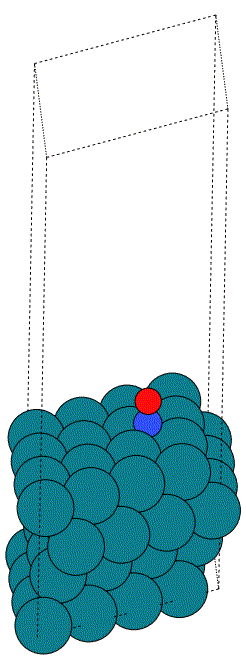

In [31]:
ImageWidget(filepath + "/gif_NEB.gif")

TS構造となったIndexを確認。<br/>
Energy, Forceをみてみると、`index=11` で、エネルギーが最大、Forceが０付近の鞍点に達している事がわかります。

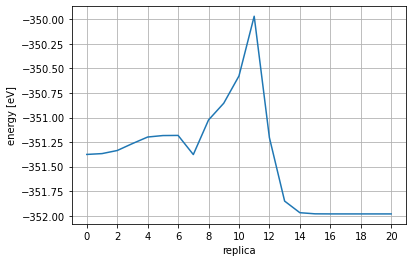

In [33]:
energies = [config.get_total_energy() for config in configs]
plt.plot(range(len(energies)),energies)
plt.xlabel("replica")
plt.ylabel("energy [eV]")
plt.xticks(np.arange(0, len(energies), 2))
plt.grid(True)
plt.show()

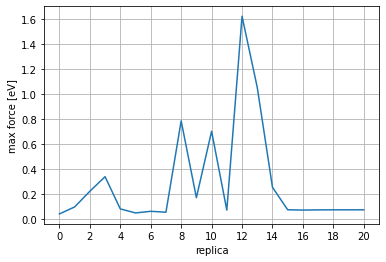

In [36]:
def calc_max_force(atoms):
    return ((atoms.get_forces() ** 2).sum(axis=1).max()) ** 0.5

mforces = [calc_max_force(config) for config in configs]
plt.plot(range(len(mforces)), mforces)
plt.xlabel("replica")
plt.ylabel("max force [eV]")
plt.xticks(np.arange(0, len(mforces), 2))
plt.grid(True)
plt.show()

初期構造　`index=0` と、遷移状態 `index=11`のエネルギー差を見ることで活性化エネルギーが計算できます。

In [ ]:
ts_index = 11
actE = energies[ts_index] - energies[0]
deltaE = energies[ts_index] - energies[-1]
print(f"actE {actE} eV, deltaE {deltaE} eV")

In [ ]:
v = view(configs, viewer='ngl')
#v.view.add_representation("ball+stick")
display(v)

### NEBやり直し

実行済みのNEB計算結果から中間イメージのほうが始状態、終状態に適した構造が出た場合に、その構造を抽出して再実行してください。

In [164]:
# IS2 = configs[9].copy()
# FS2 = configs[-1].copy()

# c = FixAtoms(indices=[atom.index for atom in IS2 if atom.position[2] <= 1])
# IS2.calc = calculator
# IS2.set_constraint(c)
# BFGS_opt = BFGS(IS2, logfile=None)
# BFGS_opt.run(fmax=0.005)
# print(IS2.get_potential_energy())

# c = FixAtoms(indices=[atom.index for atom in FS2 if atom.position[2] <= 1])
# FS2.calc = calculator
# FS2.set_constraint(c)
# BFGS_opt = BFGS(FS2, logfile=None)
# BFGS_opt.run(fmax=0.005)
# print(FS2.get_potential_energy())

In [165]:
# write(filepath+"/IS2.cif", IS2)
# write(filepath+"/FS2.cif", FS2)

In [166]:
# v = view([IS2, FS2], viewer='ngl')
# #v.view.add_representation("ball+stick")
# display(v)

In [167]:
# beads = 21
# b0 = IS2.copy()
# b1 = FS2.copy()
# configs = [b0.copy() for i in range(beads-1)] + [b1.copy()]
# for config in configs:
#     estimator = Estimator()                     # NEBでparallel=True, allowed_shared_calculator=Falseにする場合に必要
#     calculator = ASECalculator(estimator)       # NEBでparallel=True, allowed_shared_calculator=Falseにする場合に必要
#     config.calc = calculator

In [168]:
# %%time
# steps=2000

# neb = NEB(configs, k=0.05, parallel=True, climb=True, allow_shared_calculator=False)   #k：ばねの定数　最終的に0.05とか下げた方が安定する。
#                     # NEBでparallel = True, allowed_shared_calculator=Falseにしたほうが、他のjobの影響を受けにくいので高速に処理が進みます。
# neb.interpolate()
# relax = FIRE(neb, trajectory=None, logfile=filepath+"/neb_log_2.txt")

# relax.run(fmax=0.05, steps=steps)              

In [169]:
# write(filepath+"/NEB_images2.xyz", configs)

In [170]:
# os.makedirs(filepath + "/pov_NEB2/", exist_ok=True)
# os.makedirs(filepath + "/png_NEB2/", exist_ok=True)

# for h,i in enumerate(configs):
#     m = i.copy()
#     write(filepath + '/pov_NEB2/NEB_' + str(h).zfill(3) + '.pov', m, rotation='-60x, 30y, 15z')
#     write(filepath + '/png_NEB2/NEB_' + str(h).zfill(3) + '.png', m, rotation='-60x, 30y, 15z')

In [171]:
# imgs = []
# for i in sorted(glob.glob(filepath + "/png_NEB2/*.png"))[:]:
#     img = Image.open(i)
#     img.load()
#     #img = img.resize((250,480))
#     bg = Image.new("RGB", img.size, (255, 255, 255))
#     bg.paste(img, mask=img.split()[3])
#     imgs.append(bg)

# imgs[0].save(filepath + "/gif_NEB_2.gif", save_all=True, append_images=imgs[1:], optimize=False, duration=100, loop=0)

In [172]:
# energies = [config.get_total_energy() for config in configs]
# plt.plot(range(len(energies)),energies)
# plt.xlabel("replica")
# plt.ylabel("energy [eV]")
# plt.xticks(np.arange(0, beads, 2))
# plt.grid(True)
# plt.show()

In [173]:
# mforces = [config.get_forces().max() for config in configs]
# plt.plot(range(len(mforces)),mforces)
# plt.xlabel("replica")
# plt.ylabel("max force [eV]")
# plt.xticks(np.arange(0, beads, 2))
# plt.grid(True)
# plt.show()

In [174]:
# energies[13] - energies[0]

In [175]:
# v = view(configs, viewer='ngl')
# #v.view.add_representation("ball+stick")
# display(v)

<a id="chap5"></a>
## 5. 遷移状態構造の構造最適化（by Sella）

前章で得られたTS構造は、厳密な鞍点まで収束させる操作が入っていません。
ここでは、[sella](https://github.com/zadorlab/sella) というライブラリを用いて、TS構造を収束させます。

In [38]:
TSNo = 11
TS = configs[TSNo].copy()
c = FixAtoms(indices=[atom.index for atom in TS if atom.position[2] <= 1])
TS.set_constraint(c)

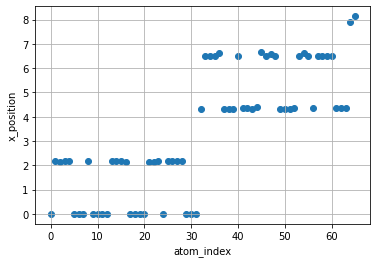

In [39]:
# 原子のz_positionを確認。
z_pos = pd.DataFrame({
    "symbol": TS.get_chemical_symbols(),
    "z": TS.get_positions()[:, 2]
})

plt.scatter(z_pos.index, z_pos["z"])
plt.grid(True)
plt.xlabel("atom_index")
plt.ylabel("z_position")
#plt.ylim(14,22)
plt.show()

In [40]:
TS.calc = calculator  
TSopt = Sella(TS)         # SellaでTSopt
%time TSopt.run(fmax=0.05)
potentialenergy = TS.get_potential_energy()
print (TS.get_potential_energy(), TS.get_forces().max())

     Step     Time          Energy         fmax         cmax       rtrust          rho
Sella   0 00:54:04     -349.968385       0.0437       0.0000       0.1950       1.0000
CPU times: user 50.8 ms, sys: 11.1 ms, total: 62 ms
Wall time: 105 ms
-349.9683853963234 0.039226174


In [41]:
write(filepath + "/TS_opt.cif", TS)

In [42]:
# TSopt前後の構造を比較
v = view([configs[TSNo], TS], viewer='ngl')
v.view.add_representation("ball+stick")
display(v)

<a id="chap6"></a>
## 6. 遷移状態の振動解析

In [43]:
# 振動計算で解析する元素はz_pos >= zzとする。
vibatoms = z_pos[z_pos["z"] >= 7.0].index
vibatoms

Int64Index([64, 65], dtype='int64')

In [44]:
# 振動計算

vibpath = filepath + "/TS_vib/vib"
os.makedirs(vibpath, exist_ok=True)
vib = Vibrations(TS, name=vibpath, indices=vibatoms)          # 振動計算する元素はココでvibatomsとして指定する。
vib.run()
vib_energies = vib.get_energies()

thermo = IdealGasThermo(vib_energies=vib_energies,
                        potentialenergy=potentialenergy,
                        atoms=TS,
                        geometry='linear',     #'monatomic', 'linear', or 'nonlinear'
                        symmetrynumber=2, spin=0, natoms=len(vibatoms))
G = thermo.get_gibbs_energy(temperature=298.15, pressure=101325.)

Enthalpy components at T = 298.15 K:
E_pot               -349.968 eV
E_ZPE                  0.034 eV
Cv_trans (0->T)        0.039 eV
Cv_rot (0->T)          0.026 eV
Cv_vib (0->T)          0.005 eV
(C_v -> C_p)           0.026 eV
-------------------------------
H                   -349.839 eV

Entropy components at T = 298.15 K and P = 101325.0 Pa:
                           S               T*S
S_trans (1 bar)    0.0022653 eV/K        0.675 eV
S_rot              0.0012601 eV/K        0.376 eV
S_elec             0.0000000 eV/K        0.000 eV
S_vib              0.0000234 eV/K        0.007 eV
S (1 bar -> P)    -0.0000011 eV/K       -0.000 eV
-------------------------------------------------
S                  0.0035477 eV/K        1.058 eV

Free energy components at T = 298.15 K and P = 101325.0 Pa:
    H       -349.839 eV
 -T*S         -1.058 eV
-----------------------
    G       -350.897 eV


In [45]:
vib.summary()

---------------------
  #    meV     cm^-1
---------------------
  0   63.3i    510.2i
  1   24.3     196.1
  2   32.9     265.3
  3   47.9     386.3
  4   58.7     473.2
  5   68.4     551.9
---------------------
Zero-point energy: 0.116 eV


In [46]:
vib.summary(log=filepath+"/vib_summary.txt")

In [47]:
# 各振動モードの表示用のtrajファイルを出力します。
vib.write_mode(n=0, kT=300*kB, nimages=30)
vib.clean()

13

In [48]:
n = 0      # summary tableを見ながら表示したい振動モードの番号を入力してください。
vib_traj = Trajectory(vibpath + f".{n}.traj")
v = view(vib_traj, viewer='ngl')
v.view.add_representation("ball+stick")
display(v)

In [49]:
write(filepath + "/vib_traj.xyz", vib_traj)

In [50]:
vib_traj = read(filepath + "/vib_traj.xyz", index=":")

In [51]:
os.makedirs(filepath + "/pov_VIB/", exist_ok=True)
os.makedirs(filepath + "/png_VIB/", exist_ok=True)

for h,i in enumerate(vib_traj):
    m = i.copy()
    write(filepath + f"/pov_VIB/VIB_{h:03}.pov", m, rotation='-60x, 30y, 15z')
    write(filepath + f"/png_VIB/VIB_{h:03}.png", m, rotation='-60x, 30y, 15z')

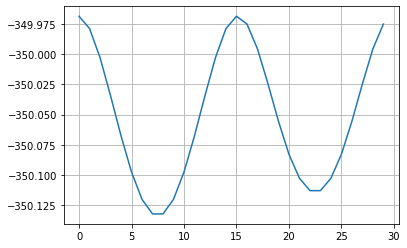

In [52]:
# 虚振動になっているか確認する。真ん中(と0)がTS。

vib_energies = []
for i in vib_traj:
    i.calc = calculator
    vib_energies.append(i.get_potential_energy())
plt.plot(range(len(vib_energies)), vib_energies)
plt.grid(True)
plt.show()

<a id="chap7"></a>
## 7. 遷移状態からの追加解析（擬似IRC計算）試作中

In [ ]:
from ase.optimize.basin import BasinHopping
from ase.optimize.minimahopping import MinimaHopping

In [ ]:
TS = read("mol_on_Rh(111)/TS_opt.cif")
TS.calc = calculator

In [ ]:
# 虚振動モードの真ん中の両隣の構造を持ってきてBFGSで最適化するだけ。
c = FixAtoms(indices=[atom.index for atom in vib_traj[15] if atom.position[2] <= 1])

IRC_IS = vib_traj[14].copy()
IRC_IS.calc = calculator
IRC_IS.set_constraint(c)
# opt = BFGS(IRC_IS, logfile=None, maxstep=1)
# opt.run(fmax=0.5)
opt = BasinHopping(IRC_IS, temperature=300 * kB, dr=0.5, optimizer=LBFGS, fmax=0.005,)
print ("IS_done")

IRC_FS = vib_traj[16].copy()
IRC_FS.calc = calculator
IRC_FS.set_constraint(c)
# opt = BFGS(IRC_FS, logfile=None, maxstep=1)
# opt.run(fmax=0.5)
opt = BasinHopping(IRC_FS, temperature=300 * kB, dr=0.5, optimizer=LBFGS, fmax=0.005,)
print ("FS_done")

In [ ]:
# 虚振動モードの真ん中の両隣の構造を持ってきてBFGSで最適化するだけ。
c = FixAtoms(indices=[atom.index for atom in TS if atom.position[2] <= 1])

IRC_IS = vib_traj[14].copy()
IRC_IS.calc = calculator
IRC_IS.set_constraint(c)
opt = BFGS(IRC_IS, logfile=None, maxstep=0.5)
opt.run(fmax=0.005, steps=500)
print ("IS_BFGS_done")
opt = MinimaHopping(IRC_IS, T0=0, fmax=0.005,)
opt(totalsteps=10)
print ("IS_MH_done")

IRC_FS = vib_traj[16].copy()
IRC_FS.calc = calculator
IRC_FS.set_constraint(c)
opt = BFGS(IRC_FS, logfile=None, maxstep=0.5)
opt.run(fmax=0.005, steps=500)
print ("FS_BFGS_done")
#opt = MinimaHopping(IRC_FS, T0=0, fmax=0.005,)
#opt(totalsteps=10)
print ("FS_MH_done")

In [ ]:
v = view([IRC_IS, TS, IRC_FS], viewer='ngl')
v.view.add_representation("ball+stick")
display(v)

In [ ]:
# NEBで計算したIS, TS, FSのenergyとTSopt+IRCの結果を比較する。
plt.plot([0,1,2], [configs[0].get_potential_energy(), configs[TSNo].get_potential_energy(), configs[-1].get_potential_energy()], label="NEB")
plt.plot([0,1,2], [IRC_IS.get_potential_energy(), TS.get_potential_energy(), IRC_FS.get_potential_energy()], label="TSopt+IRC")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(TS.get_potential_energy() - IRC_IS.get_potential_energy())
print(TS.get_potential_energy() - IRC_FS.get_potential_energy())

In [ ]:
write(filepath + "/IS_IRC.xyz",IRC_IS)
write(filepath + "/FS_IRC.xyz",IRC_FS)